In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os 
import joblib
from sklearn.linear_model import LogisticRegression

## Analysis

In [80]:
df = pd.read_csv('Data/Diabetes/diabetes2.csv')

In [81]:
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [82]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [83]:
df.dtypes

Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object

In [84]:
df.isna().any()

Pregnancies                 False
Glucose                     False
BloodPressure               False
SkinThickness               False
Insulin                     False
BMI                         False
DiabetesPedigreeFunction    False
Age                         False
Outcome                     False
dtype: bool

## Model & Training

In [85]:
out_col = 'Outcome'
feature_cols = list(set(df.columns) - set([out_col]))

In [86]:
def split(df: pd.DataFrame, folds=5):
    df = df.sample(frac=1, random_state=7).reset_index(drop=True)
    num = len(df) // folds
    left = len(df) % folds
    df_folds = []
    prev = 0
    for i in range(folds):
        length = num + (left > 0)
        df_ = df.iloc[prev: prev + length].copy().reset_index(drop=True)
        df_folds.append(df_)
        prev += length
        left -= 1
    return df_folds

def form_train_val(folds, val_fold):
    train_folds = [folds[i] for i in range(len(folds)) if i != val_fold]
    train_df = pd.concat(train_folds).reset_index(drop=True)
    val_df = folds[val_fold].copy()
    return train_df, val_df

In [87]:
folds = split(df)

In [88]:
def BCE(y_actual, y_pred):
    return -np.mean(y_actual * np.log(y_pred) + (1 - y_actual) * np.log(1 - y_pred))
    
def accuracy(y_actual, y_pred):
    return sum([y_pred[i] == y_actual[i] for i in range(len(y_actual))]) / len(y_actual)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [89]:
class LogRegression:
    """
    Logistic Regression with L2 Regularisation
    Utilises Binary Cross Entropy loss as loss criterion
    Uses Batch Gradient Descent for updates
    """

    def __init__(self, normalise=True, lr=0.01, reg_lambda=0):
        self.normalise = normalise # Gaussian Normalisation
        self.lr = lr
        self.reg_lambda = reg_lambda

    def fit(self, X_df, y_df, X_val_df=None, y_val_df=None, epochs=1000, precision=1e-10, display=True):
        X_df_ = None
        if self.normalise:
            self.mean = X_df.mean()
            self.std = X_df.std()
            X_df_ = (X_df - self.mean) / self.std
        else:
            X_df_ = X_df.copy()
        X_df_['_bias'] = np.ones(len(X_df_))
        X = X_df_.to_numpy()
        y = np.array(y_df)
        self.num_samples, self.dim = X.shape

        validation = X_val_df is not None
        X_val = None
        y_val = None
        if validation:
            X_val_df_ = None
            if self.normalise:
                X_val_df_ = (X_val_df - self.mean) / self.std
            else:
                X_val_df_ = X_val_df.copy()
            X_val_df_['bias'] = np.ones(len(X_val_df_))
            X_val = X_val_df_.to_numpy()
            y_val = np.array(y_val_df)

        self.w = np.zeros(self.dim)
        self.train_losses = []
        self.train_accuracies = []
        if validation:
            self.validation_losses = []
            self.validation_accuracies = []
        iters = 0
        prev_step_size = np.inf

        while iters < epochs and prev_step_size > precision:
            self.train_losses.append(self.loss(y, self.prob(X)))
            self.train_accuracies.append(accuracy(y, self.predict(X_df)))
            if validation:
                self.validation_losses.append(self.loss(y_val, self.prob(X_val)))
                self.validation_accuracies.append(accuracy(y_val, self.predict(X_val_df)))

            if display:
                print(f'Epoch {iters + 1} ----')
                print(f'Training loss: {self.train_losses[-1]}')
                print(f'Training accuracy: {self.train_accuracies[-1]}')
                if validation:
                    print(f'Validation loss: {self.validation_losses[-1]}')
                    print(f'Validation accuracy: {self.validation_accuracies[-1]}')

            w_ = self.w - self.lr * self.grad(X, y)
            prev_step_size = np.sum((self.w - w_) ** 2)
            self.w = w_
            iters += 1
        
        self.epochs_run = iters

    def loss(self, y_actual, y_pred):
        return BCE(y_actual, y_pred) + self.reg_lambda * np.sum(self.w ** 2)

    def prob(self, X):
        return sigmoid(X @ self.w)    

    def grad(self, X, y_actual):
        y_pred = self.prob(X)
        gradient = ((y_pred - y_actual) @ X) / self.num_samples + 2 * self.reg_lambda * self.w
        return gradient

    def predict(self, X_test):
        if self.normalise:
            X_test = (X_test - self.mean) / self.std
        else:
            X_test = X_test.copy()
        X_test['_bias'] = np.ones(len(X_test))
        y_pred = np.array([int((self.w.T @ x) >= 0) for x in X_test.to_numpy()])
        return y_pred


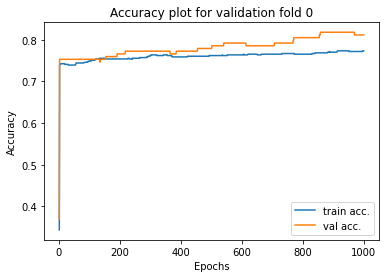

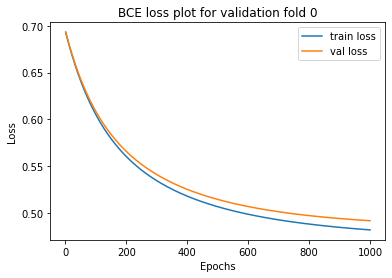

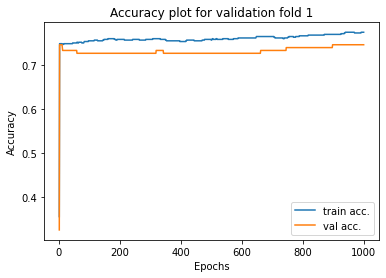

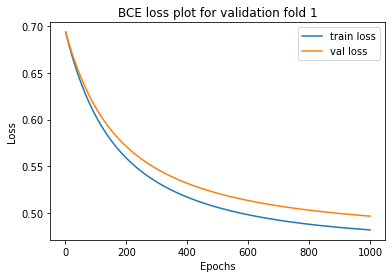

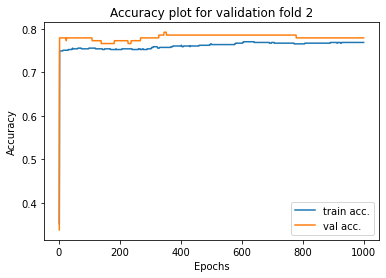

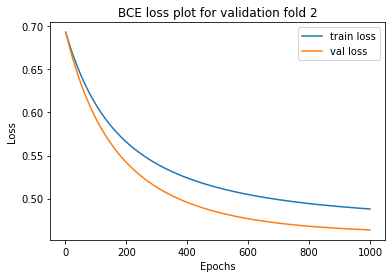

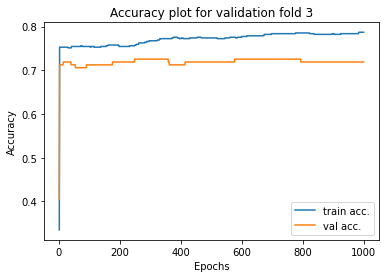

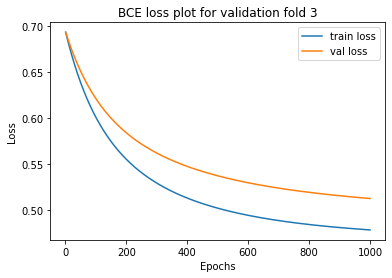

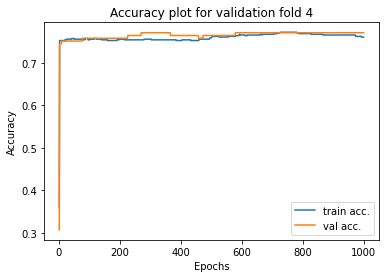

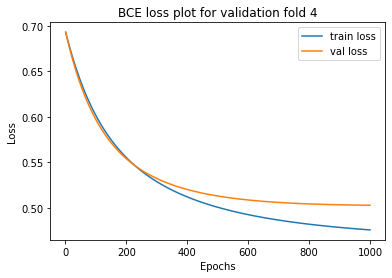

In [90]:
log_reg_df = {'Validation fold': [], 'Train Acc.': [], 'Validation Acc.': []}
log_reg_models_path = f'Weights/2/log-reg-models.sav'
log_reg_models_exists = os.path.exists(log_reg_models_path)
log_reg_models = joblib.load(log_reg_models_path) if log_reg_models_exists else []
for val_fold in range(len(folds)):
    train_df, val_df = form_train_val(folds, val_fold)
    log_reg = None
    if not log_reg_models_exists:
        log_reg = LogRegression()
        log_reg.fit(train_df[feature_cols], train_df[out_col], val_df[feature_cols], val_df[out_col], display=False)
        log_reg_models.append(log_reg)
    else:
        log_reg = log_reg_models[val_fold]
    
    x_plot = np.arange(1, log_reg.epochs_run + 1)
    plt.plot(x_plot, log_reg.train_accuracies, label='train acc.')
    plt.plot(x_plot, log_reg.validation_accuracies, label='val acc.')
    plt.title(f'Accuracy plot for validation fold {val_fold}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    x_plot = np.arange(1, log_reg.epochs_run + 1)
    plt.plot(x_plot, log_reg.train_losses, label='train loss')
    plt.plot(x_plot, log_reg.validation_losses, label='val loss')
    plt.title(f'BCE loss plot for validation fold {val_fold}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    log_reg_df['Validation fold'].append(val_fold)
    log_reg_df['Train Acc.'].append(log_reg.train_accuracies[-1])
    log_reg_df['Validation Acc.'].append(log_reg.validation_accuracies[-1])

log_reg_df = pd.DataFrame(log_reg_df)
if not log_reg_models_exists:
    joblib.dump(log_reg_models, log_reg_models_path)

In [91]:
log_reg_df

,Validation fold,Train Acc.,Validation Acc.
0,0,0.773616,0.811688
1,1,0.775244,0.746753
2,2,0.768730,0.779221
3,3,0.786992,0.718954
4,4,0.760976,0.771242


100%|██████████| 25/25 [00:00<00:00, 176.97it/s]


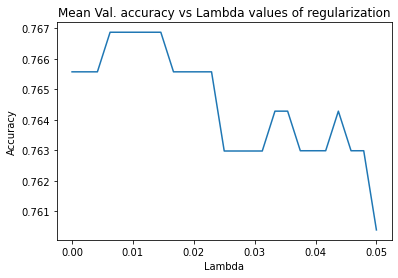

In [92]:
reg_lambdas = np.linspace(0, 0.05, 25)
mean_val_accuracy = []
log_reg_lambda_models_path = f'Weights/2/log-reg-lambda-models.sav'
log_reg_lambda_models_exists = os.path.exists(log_reg_lambda_models_path)
log_reg_lambda_models = joblib.load(log_reg_lambda_models_path) if log_reg_lambda_models_exists else {}
for reg_lambda in tqdm(reg_lambdas):    
    val_accuracies = []
    for val_fold in range(len(folds)):
        train_df, val_df = form_train_val(folds, val_fold)
        log_reg = None
        if not log_reg_lambda_models_exists:
            log_reg = LogRegression(reg_lambda=reg_lambda)
            log_reg.fit(train_df[feature_cols], train_df[out_col], val_df[feature_cols], val_df[out_col], display=False)
            log_reg_lambda_models[(reg_lambda, val_fold)] = log_reg
        else:
            log_reg = log_reg_lambda_models[(reg_lambda, val_fold)]
        val_accuracies.append(log_reg.validation_accuracies[-1])
    mean_val_accuracy.append(np.mean(val_accuracies))

if not log_reg_lambda_models_exists:
    joblib.dump(log_reg_lambda_models, log_reg_lambda_models_path)

# find highest lambda value with the larget mean validation accuracy
max_reg_lambda_idx = len(mean_val_accuracy) - np.argmax(mean_val_accuracy[::-1]) - 1
optimal_reg_lambda = reg_lambdas[max_reg_lambda_idx]

plt.plot(reg_lambdas, mean_val_accuracy)
plt.title('Mean Val. accuracy vs Lambda values of regularization')
plt.xlabel('Lambda')
plt.ylabel('Accuracy')
plt.show()

In [93]:
optimal_reg_lambda

0.014583333333333334

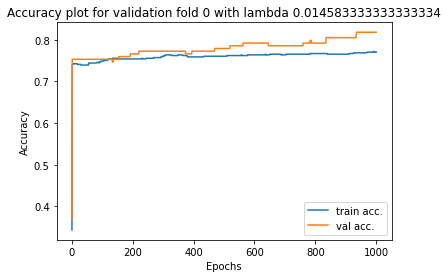

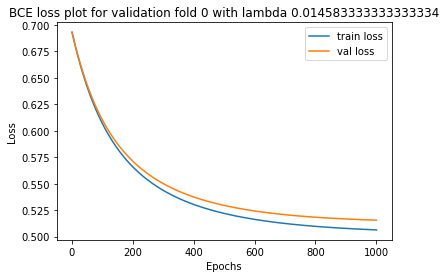

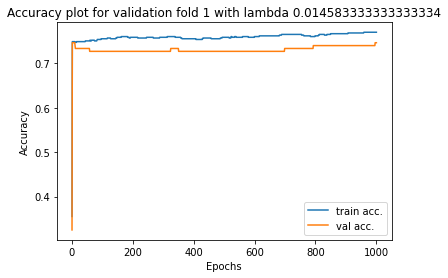

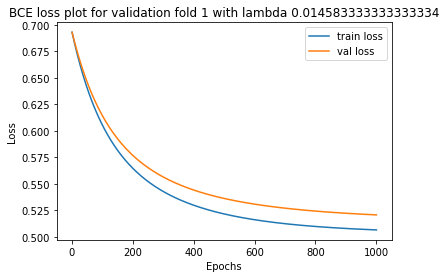

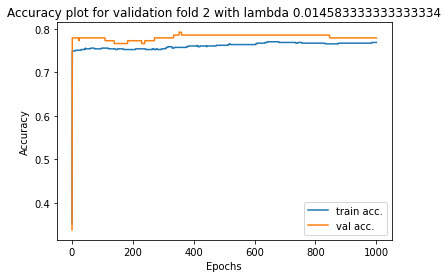

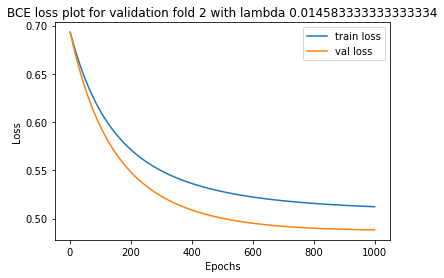

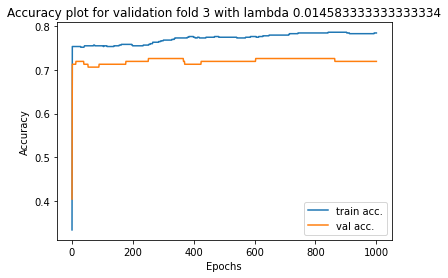

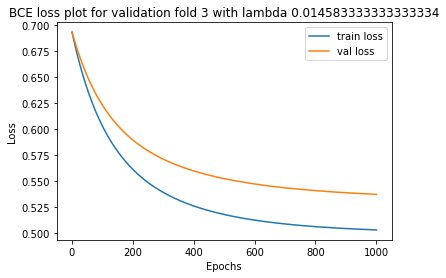

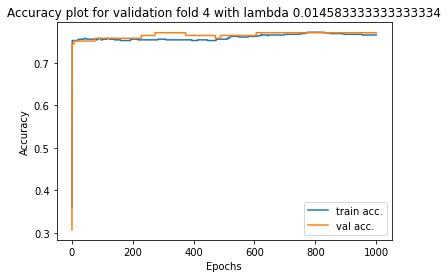

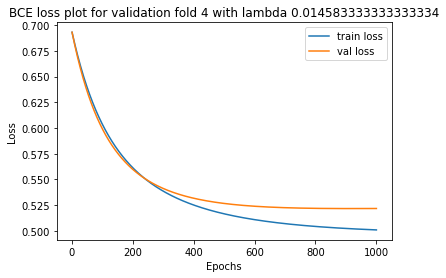

In [94]:
log_reg_lambda_df = {'Validation fold': [], 'Train Acc.': [], 'Validation Acc.': []}
log_reg_olambda_models_path = f'Weights/2/log-reg-olambda-models.sav'
log_reg_olambda_models_exists = os.path.exists(log_reg_olambda_models_path)
log_reg_olambda_models = joblib.load(log_reg_olambda_models_path) if log_reg_olambda_models_exists else []
for val_fold in range(len(folds)):
    train_df, val_df = form_train_val(folds, val_fold)
    log_reg = None
    if not log_reg_olambda_models_exists:
        log_reg = LogRegression(reg_lambda=optimal_reg_lambda)
        log_reg.fit(train_df[feature_cols], train_df[out_col], val_df[feature_cols], val_df[out_col], display=False)
        log_reg_olambda_models.append(log_reg)
    else:
        log_reg = log_reg_olambda_models[val_fold]
    
    x_plot = np.arange(1, log_reg.epochs_run + 1)
    plt.plot(x_plot, log_reg.train_accuracies, label='train acc.')
    plt.plot(x_plot, log_reg.validation_accuracies, label='val acc.')
    plt.title(f'Accuracy plot for validation fold {val_fold} with lambda {optimal_reg_lambda}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    x_plot = np.arange(1, log_reg.epochs_run + 1)
    plt.plot(x_plot, log_reg.train_losses, label='train loss')
    plt.plot(x_plot, log_reg.validation_losses, label='val loss')
    plt.title(f'BCE loss plot for validation fold {val_fold} with lambda {optimal_reg_lambda}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    log_reg_lambda_df['Validation fold'].append(val_fold)
    log_reg_lambda_df['Train Acc.'].append(log_reg.train_accuracies[-1])
    log_reg_lambda_df['Validation Acc.'].append(log_reg.validation_accuracies[-1])

log_reg_lambda_df = pd.DataFrame(log_reg_lambda_df)
if not log_reg_olambda_models_exists:
    joblib.dump(log_reg_olambda_models, log_reg_olambda_models_path)

In [95]:
log_reg_lambda_df

,Validation fold,Train Acc.,Validation Acc.
0,0,0.770358,0.818182
1,1,0.770358,0.746753
2,2,0.768730,0.779221
3,3,0.783740,0.718954
4,4,0.765854,0.771242


In [96]:
log_reg_df.mean()[['Train Acc.', 'Validation Acc.']]

Train Acc.         0.773111
Validation Acc.    0.765572
dtype: float64

In [97]:
log_reg_lambda_df.mean()[['Train Acc.', 'Validation Acc.']]

Train Acc.         0.771808
Validation Acc.    0.766870
dtype: float64

In [98]:
mean_dist_unregularized = np.mean([np.sum(x.w ** 2) for x in log_reg_models])
mean_dist_regularized = np.mean([np.sum(x.w ** 2) for x in log_reg_olambda_models])
mean_dist_unregularized, mean_dist_regularized

(1.4866829173322713, 1.1995173286141736)

## Using sklearn

In [99]:
log_reg_sklearn_df = {'Validation fold': [], 'Train Acc.': [], 'Validation Acc.': []}
log_reg_sklearn_models_path = f'Weights/2/log-reg-sklearn-models.sav'
log_reg_sklearn_models_exists = os.path.exists(log_reg_sklearn_models_path)
log_reg_sklearn_models = joblib.load(log_reg_sklearn_models_path) if log_reg_sklearn_models_exists else []
for val_fold in range(len(folds)):
    train_df, val_df = form_train_val(folds, val_fold)
    # explicit standardization
    mean_train_df = train_df[feature_cols].mean()
    std_train_df = train_df[feature_cols].std()
    train_df[feature_cols] = (train_df[feature_cols] - mean_train_df) / std_train_df
    val_df[feature_cols] = (val_df[feature_cols] - mean_train_df) / std_train_df

    log_reg = None
    if not log_reg_sklearn_models_exists:
        log_reg = LogisticRegression(penalty='none', random_state=7)
        log_reg.fit(train_df[feature_cols], train_df[out_col])
        log_reg_sklearn_models.append(log_reg)
    else:
        log_reg = log_reg_sklearn_models[val_fold]
    
    train_acc = log_reg.score(train_df[feature_cols], train_df[out_col])
    val_acc = log_reg.score(val_df[feature_cols], val_df[out_col])

    log_reg_sklearn_df['Validation fold'].append(val_fold)
    log_reg_sklearn_df['Train Acc.'].append(train_acc)
    log_reg_sklearn_df['Validation Acc.'].append(val_acc)

log_reg_sklearn_df = pd.DataFrame(log_reg_sklearn_df)
if not log_reg_sklearn_models_exists:
    joblib.dump(log_reg_sklearn_models, log_reg_sklearn_models_path)

In [100]:
log_reg_sklearn_df

,Validation fold,Train Acc.,Validation Acc.
0,0,0.775244,0.785714
1,1,0.776873,0.766234
2,2,0.770358,0.785714
3,3,0.783740,0.738562
4,4,0.775610,0.784314


In [101]:
log_reg_l2_sklearn_df = {'Validation fold': [], 'Train Acc.': [], 'Validation Acc.': []}
log_reg_l2_sklearn_models_path = f'Weights/2/log-reg-l2-sklearn-models.sav'
log_reg_l2_sklearn_models_exists = os.path.exists(log_reg_l2_sklearn_models_path)
log_reg_l2_sklearn_models = joblib.load(log_reg_l2_sklearn_models_path) if log_reg_l2_sklearn_models_exists else []
for val_fold in range(len(folds)):
    train_df, val_df = form_train_val(folds, val_fold)
    # explicit standardization
    mean_train_df = train_df[feature_cols].mean()
    std_train_df = train_df[feature_cols].std()
    train_df[feature_cols] = (train_df[feature_cols] - mean_train_df) / std_train_df
    val_df[feature_cols] = (val_df[feature_cols] - mean_train_df) / std_train_df

    log_reg = None
    if not log_reg_l2_sklearn_models_exists:
        log_reg = LogisticRegression(penalty='l2', random_state=7)
        log_reg.fit(train_df[feature_cols], train_df[out_col])
        log_reg_l2_sklearn_models.append(log_reg)
    else:
        log_reg = log_reg_l2_sklearn_models[val_fold]
    
    train_acc = log_reg.score(train_df[feature_cols], train_df[out_col])
    val_acc = log_reg.score(val_df[feature_cols], val_df[out_col])

    log_reg_l2_sklearn_df['Validation fold'].append(val_fold)
    log_reg_l2_sklearn_df['Train Acc.'].append(train_acc)
    log_reg_l2_sklearn_df['Validation Acc.'].append(val_acc)

log_reg_l2_sklearn_df = pd.DataFrame(log_reg_l2_sklearn_df)
if not log_reg_l2_sklearn_models_exists:
    joblib.dump(log_reg_l2_sklearn_models, log_reg_l2_sklearn_models_path)

In [102]:
log_reg_l2_sklearn_df

,Validation fold,Train Acc.,Validation Acc.
0,0,0.775244,0.785714
1,1,0.776873,0.766234
2,2,0.770358,0.792208
3,3,0.783740,0.738562
4,4,0.775610,0.784314


In [103]:
log_reg_sklearn_df.mean()[['Train Acc.', 'Validation Acc.']]

Train Acc.         0.776365
Validation Acc.    0.772108
dtype: float64

In [104]:
log_reg_l2_sklearn_df.mean()[['Train Acc.', 'Validation Acc.']]

Train Acc.         0.776365
Validation Acc.    0.773406
dtype: float64